In [53]:
import yfinance as yf
import pandas as pd
import numpy as np

# 设置资产代码与时间范围
assets = {
    "S&P 500": "^GSPC",
    "EUR/USD": "EURUSD=X"
}
start_date = "2010-01-01"
end_date = "2024-05-31"

data = {}
for name, ticker in assets.items():
    df = yf.download(ticker, start=start_date, end=end_date)
    # 使用 'Close' 而非 'Adj Close'
    data[name] = df["Close"]

# 合并为一个DataFrame并去除空值
df_prices = pd.concat(data, axis=1).dropna()

# 计算对数收益率
log_returns = np.log(df_prices / df_prices.shift(1)).dropna()

# 输出描述性统计
summary_stats = log_returns.describe().T
summary_stats["Skewness"] = log_returns.skew()
summary_stats["Kurtosis"] = log_returns.kurtosis()

# 显示表格
df_prices.to_csv("raw_prices_2010_2024.csv")
summary_stats.to_csv("descriptive_statistics.csv")



C:\Users\rjx10\AppData\Local\Temp\ipykernel_8416\3184944157.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\rjx10\AppData\Local\Temp\ipykernel_8416\3184944157.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


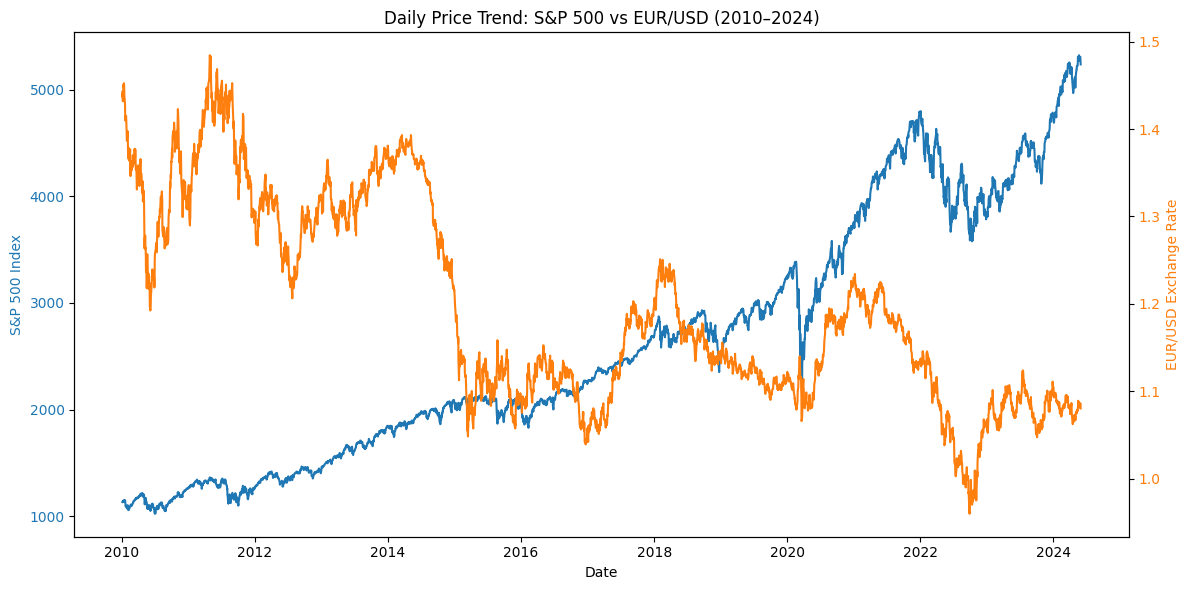

In [54]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

# 主坐标轴：S&P 500
ax1.plot(df_prices.index, df_prices["S&P 500"], color="tab:blue", label="S&P 500")
ax1.set_xlabel("Date")
ax1.set_ylabel("S&P 500 Index", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# 副坐标轴：EUR/USD
ax2 = ax1.twinx()
ax2.plot(df_prices.index, df_prices["EUR/USD"], color="tab:orange", label="EUR/USD")
ax2.set_ylabel("EUR/USD Exchange Rate", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

# 标题 & 网格
plt.title("Daily Price Trend: S&P 500 vs EUR/USD (2010–2024)")
fig.tight_layout()
plt.show()



In [55]:
# 确认两个资产是否在相同日期数量下对齐
print(df_prices.isna().sum())      # 检查是否仍有缺失
print(df_prices.shape)             # 查看数据总行数和列数
print(df_prices.index[-5:])        # 查看末尾是否对齐


         Ticker  
S&P 500  ^GSPC       0
EUR/USD  EURUSD=X    0
dtype: int64
(3621, 2)
DatetimeIndex(['2024-05-23', '2024-05-24', '2024-05-28', '2024-05-29',
               '2024-05-30'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [56]:
log_returns.to_csv("log_returns_2010_2024.csv")

In [57]:
from statsmodels.tsa.stattools import adfuller

for col in log_returns.columns:
    result = adfuller(log_returns[col])
    print(f"ADF Test for {col}:")
    print(f"ADF Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}")
    print("-" * 40)


ADF Test for ('S&P 500', '^GSPC'):
ADF Statistic: -13.0884, p-value: 0.0000
----------------------------------------
ADF Test for ('EUR/USD', 'EURUSD=X'):
ADF Statistic: -61.5575, p-value: 0.0000
----------------------------------------


In [58]:
from arch import arch_model
import matplotlib.pyplot as plt

# 创建容器保存结果
garch_results = {}
residuals = pd.DataFrame(index=log_returns.index)
volatility = pd.DataFrame(index=log_returns.index)

# 对每个资产拟合 GARCH(1,1)
for col in log_returns.columns:
    print(f"--- Fitting GARCH(1,1) for {col} ---")
    model = arch_model(log_returns[col], vol='Garch', p=1, q=1, dist='normal')  # 如需厚尾可换为 't'
    result = model.fit(disp='off')
    
    # 保存结果
    garch_results[col] = result
    residuals[col] = result.resid
    volatility[col] = result.conditional_volatility
    
    # 打印模型简要摘要
    print(result.summary())
    print("\n")

# 保存残差与波动率
residuals.to_csv("garch_residuals.csv")
volatility.to_csv("garch_volatility.csv")


--- Fitting GARCH(1,1) for ('S&P 500', '^GSPC') ---
                      Constant Mean - GARCH Model Results                       
Dep. Variable:     ('S&P 500', '^GSPC')   R-squared:                       0.000
Mean Model:               Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GARCH   Log-Likelihood:                11993.9
Distribution:                    Normal   AIC:                          -23979.9
Method:              Maximum Likelihood   BIC:                          -23955.1
                                          No. Observations:                 3620
Date:                    周一, 6月 23 2025   Df Residuals:                     3619
Time:                          17:03:08   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
-----------------------------------------------------------------

c:\Users\rjx10\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001206. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\rjx10\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.049e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\rjx10\A

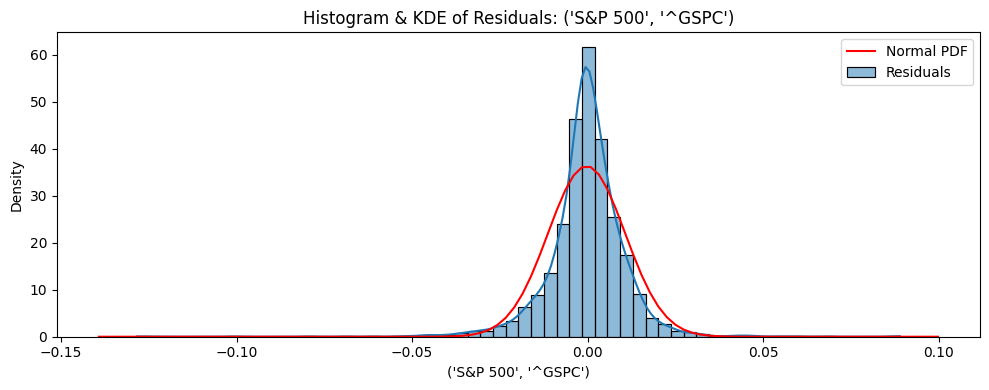

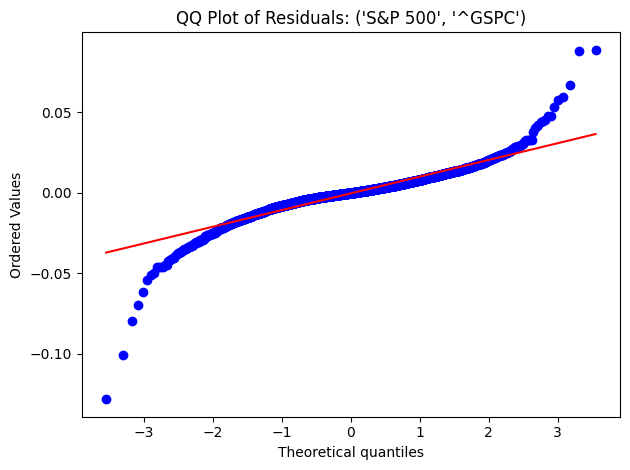

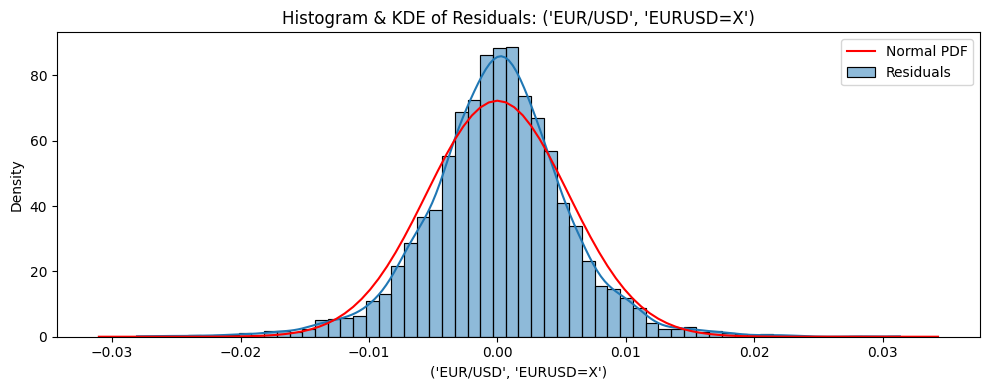

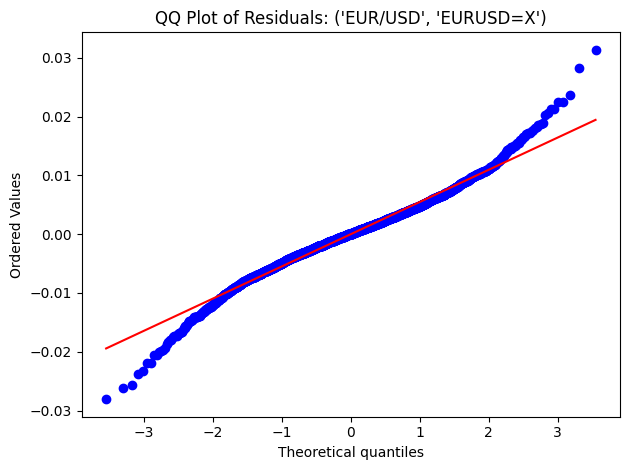

In [ ]:
import scipy.stats as stats
import seaborn as sns

# 选择资产
for col in residuals.columns:
    resid = residuals[col].dropna()

    # 1. 残差直方图 + 核密度
    plt.figure(figsize=(10, 4))
    sns.histplot(resid, kde=True, stat="density", bins=60, label="Residuals")
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    plt.plot(x, stats.norm.pdf(x, resid.mean(), resid.std()), label="Normal PDF", color="red")
    plt.title(f"Histogram & KDE of Residuals: {col}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2. QQ图对比正态分布
    stats.probplot(resid, dist="norm", plot=plt)
    plt.title(f"QQ Plot of Residuals: {col}")
    plt.tight_layout()
    plt.show()

    # 3. 拟合 t 分布，估计自由度等参数
    df_t, loc_t, scale_t = stats.t.fit(resid)

    # 4. 将残差转换为 Copula 输入 u 值（u ~ Uniform[0,1]）
    u_empirical = stats.rankdata(resid) / (len(resid) + 1)  # 经验分布法
    u_t_dist = stats.t.cdf(resid, df=df_t, loc=loc_t, scale=scale_t)

    # 保存为 DataFrame（供下一步构建 Copula）
    residuals[f"{col}_u_empirical"] = u_empirical
    residuals[f"{col}_u_t"] = u_t_dist

# 保存带 u 值的残差数据
residuals.to_csv("copula_inputs_with_residuals.csv")


In [60]:
print(residuals.columns.tolist())

[('S&P 500', '^GSPC'), ('EUR/USD', 'EURUSD=X'), "('S&P 500', '^GSPC')_u_empirical", "('S&P 500', '^GSPC')_u_t", "('EUR/USD', 'EURUSD=X')_u_empirical", "('EUR/USD', 'EURUSD=X')_u_t"]


In [61]:
copula_data = residuals[[
    "('S&P 500', '^GSPC')_u_t",
    "('EUR/USD', 'EURUSD=X')_u_t"
]].copy()

# 重命名列名为简洁格式，便于后续使用
copula_data.columns = ['S&P 500', 'EUR/USD']

# 删除缺失值
copula_data = copula_data.dropna()

# 检查输出
print(copula_data.head())


             S&P 500   EUR/USD
Date                          
2010-01-05  0.648975  0.201143
2010-01-06  0.501604  0.717360
2010-01-07  0.693061  0.115047
2010-01-08  0.636602  0.902817
2010-01-11  0.573016  0.914984


In [62]:
from scipy.stats import norm
import numpy as np

# 将伪观测值转为正态分布中的 z 值
norm_inv = norm.ppf(copula_data)

# 计算相关系数矩阵（皮尔逊相关性）
corr_matrix = np.corrcoef(norm_inv.T)

print("Estimated correlation matrix (for Gaussian Copula):")
print(corr_matrix)


Estimated correlation matrix (for Gaussian Copula):
[[1.         0.03353555]
 [0.03353555 1.        ]]


In [63]:
from numpy.random import multivariate_normal

# 设置模拟参数
n_sim = 10000
mean = [0, 0]  # 标准正态分布的均值
cov = corr_matrix  # 上面估计的协方差矩阵

# 模拟正态变量
sim_norm = multivariate_normal(mean, cov, size=n_sim)

# 转为 Copula 下的联合分布（u1, u2）
sim_u = norm.cdf(sim_norm)
sim_u_df = pd.DataFrame(sim_u, columns=['S&P 500', 'EUR/USD'])

# 查看模拟结果（单位均为 U[0,1]）
print(sim_u_df.head())


    S&P 500   EUR/USD
0  0.297734  0.587988
1  0.410654  0.205866
2  0.089700  0.177645
3  0.665506  0.603486
4  0.044720  0.263707


In [64]:
# 创建空的 DataFrame，行数与 sim_u_df 一致，列为资产名
sim_returns = pd.DataFrame(index=sim_u_df.index, columns=sim_u_df.columns)

# 使用经验分布法将 Copula 模拟的 u 值映射为历史收益率
for col in sim_u_df.columns:
    u_vals = sim_u_df[col].values
    hist = historical_returns[col].dropna()
    sorted_hist = np.sort(hist.values)

    quantile_indices = (u_vals * (len(sorted_hist) - 1)).astype(int)

    # ✅ 检查索引分布
    print(f"{col} | quantile_indices stats:")
    print(f"  min: {quantile_indices.min()}, max: {quantile_indices.max()}, unique: {np.unique(quantile_indices).shape[0]}")

    sim_returns[col] = pd.Series(sorted_hist[quantile_indices].ravel(), index=sim_u_df.index)


# 检查输出
print(sim_returns.head())



S&P 500 | quantile_indices stats:
  min: 0, max: 3618, unique: 3363
EUR/USD | quantile_indices stats:
  min: 0, max: 3618, unique: 3392
    S&P 500   EUR/USD
0  0.003768  0.002307
1 -0.011057 -0.001190
2 -0.011079 -0.012275
3  0.000767  0.002857
4  0.003284 -0.000438


In [ ]:
# 假设等权重组合（你也可以调整为其他权重）
weights = np.array([0.5, 0.5])

# 计算组合收益率（每一行是一个模拟样本）
portfolio_returns = sim_returns.dot(weights)

# 计算 VaR 和 ES（以 95% 置信水平为例）
alpha = 0.05
VaR_95 = np.quantile(portfolio_returns, alpha)
ES_95 = portfolio_returns[portfolio_returns <= VaR_95].mean()

print(f"Portfolio VaR (95%): {VaR_95:.5f}")
print(f"Portfolio ES  (95%): {ES_95:.5f}")


Portfolio VaR (95%): -0.00881
Portfolio ES  (95%): -0.01271


进行 传统方法（正态假设 + 历史模拟）下的组合 VaR / ES 计算，用于与 Copula 模拟结果做对比

In [69]:
# 假设 historical_returns 是你已有的历史日收益率
portfolio_returns_hist = historical_returns.dot(weights)

VaR_hist = np.quantile(portfolio_returns_hist, alpha)
ES_hist = portfolio_returns_hist[portfolio_returns_hist <= VaR_hist].mean()

print(f"Historical VaR (95%): {VaR_hist:.5f}")
print(f"Historical ES  (95%): {ES_hist:.5f}")


Historical VaR (95%): -0.00878
Historical ES  (95%): -0.01315


In [70]:
print("=== Portfolio Risk Measures Comparison ===")
print(f"{'Method':<20} {'VaR (95%)':>12} {'ES (95%)':>12}")
print(f"{'Copula Simulated':<20} {VaR_95:>12.5f} {ES_95:>12.5f}")
print(f"{'Historical':<20} {VaR_hist:>12.5f} {ES_hist:>12.5f}")


=== Portfolio Risk Measures Comparison ===
Method                  VaR (95%)     ES (95%)
Copula Simulated         -0.00881     -0.01271
Historical               -0.00878     -0.01315
